# Trend Volatility Replication

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_1samp

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

# Getting Data

In [2]:
fut_path    = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\FuturesData.parquet"
hf_path     = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\hf_indices.parquet"
ticker_path = r"A:\BBGFuturesManager_backup_backup\root\fut_tickers.xlsx"
spx_path    = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\spx.parquet"

In [3]:
df_px = (pd.read_parquet(
    path = fut_path, engine = "pyarrow").
    pivot(index = "date", columns = "security", values = "PX_LAST"))

In [4]:
df_dt = (df_px.diff().apply(
    lambda x: x / x.ewm(span = 10, adjust = False).std()))

# Preparing the signal

In [5]:
#def get_signal(df_px: pd.DataFrame, df_dt: pd.DataFrame,window: int = 180) -> tuple: 

window = 180
df_tf_signal = (df_dt.apply(
    lambda x: x.ewm(span = window, adjust = False).mean()).
    shift().
    reset_index().
    melt(id_vars = "date"))

df_vol_signal1 = (df_px.pct_change().apply(
    lambda x: x.ewm(span = window, adjust = False).std() - x.ewm(span = window / 2, adjust = False).std()).
    shift().
    reset_index().
    melt(id_vars = ["date"]))

df_vol_signal2 = (df_dt.apply(
    lambda x: x.ewm(span = window, adjust = False).std() - x.ewm(span = window / 2, adjust = False).std()).
    shift().
    reset_index().
    melt(id_vars = "date"))

In [6]:
df_signal = (pd.concat([
    df_tf_signal.assign(signal = "trend"),
    df_vol_signal1.assign(signal = "rt_vol"),
    df_vol_signal2.assign(signal = "dt_vol")]).
    rename(columns = {"value": "lag_signal"}).
    dropna())

In [7]:
df_signal_rtn = (df_px.pct_change().reset_index().melt(
    id_vars = "date", value_name = "px_rtn").
    dropna().
    merge(right = df_signal, how = "inner", on = ["date", "security"]).
    query("security != 'SER1 Comdty'").
    assign(signal_rtn = lambda x: np.sign(x.lag_signal) * x.px_rtn))

# Analyzing the returns

In [8]:
renamer = {
        "trend" : "Trend Following Replicator",
        "rt_vol": r"$\sigma_{rt}$" + " Vol. Diff",
        "dt_vol": r"$\sigma_{dt}$" + " Vol. Diff"}

In [9]:
df_risk_rtn = (df_signal_rtn.pivot(
    index = "date", columns = ["signal", "security"], values = "signal_rtn").
    apply(lambda x: x * (0.5 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    reset_index().
    melt(id_vars = "date", value_name = "scaled_rtn"))

In [10]:
df_port_rtn = (df_risk_rtn.drop(
    columns = ["security"]).
    groupby(["date", "signal"]).
    agg("mean").
    reset_index().
    rename(columns = {"scaled_rtn": "port_rtn"}).
    dropna())

<AxesSubplot:title={'center':'Comparing Trend Replicator vs. Difference in Volatility Using $D_t$ and $r_t$\nFrom 1990-01-08 to 2024-10-30'}, xlabel='date', ylabel='Cuml. Reg. Log-Scaled'>

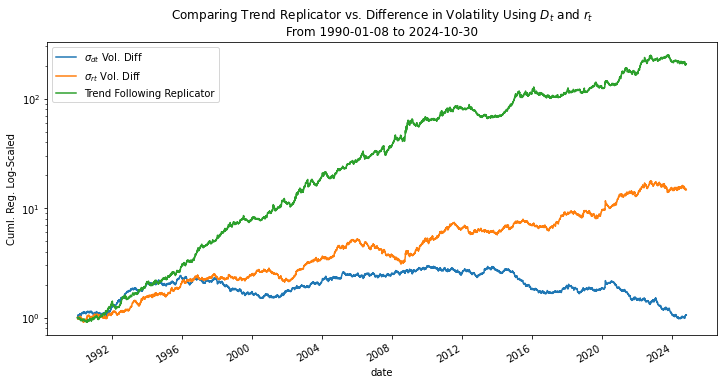

In [11]:
(df_port_rtn.pivot(
    index = "date", columns = "signal", values = "port_rtn").
    dropna().
    reset_index().
    melt(id_vars = "date", value_name = "port_rtn").
    assign(port_rtn = lambda x: np.where(x.date == x.date.min(), 0, x.port_rtn)).
    rename(columns = {"signal": ""}).
    pivot(index = "date", columns = "", values = "port_rtn").
    apply(lambda x: np.cumprod(1 + x)).
    rename(columns = renamer).
    plot(
        logy    = True,
        ylabel  = "Cuml. Reg. Log-Scaled",
        figsize = (12,6),
        title   = (
            "Comparing Trend Replicator vs. Difference in Volatility Using " + r"$D_t$" + " and " + r"$r_t$" + 
            "\nFrom {} to {}".format(
                df_port_rtn.date.min().date(),
                df_port_rtn.date.max().date()))))

Below is a table of the sharpe across the different strategies it's evident that the performance using $D_t$ does not perform well. 

In [12]:
(df_port_rtn.query(
    "date != date.min()").
    drop(columns = ["date"]).
    groupby("signal").
    agg(lambda x: x.mean() / x.std() * np.sqrt(252)).
    rename(columns = {"port_rtn": "sharpe"}).
    reset_index().
    replace(renamer))

,signal,sharpe
0,$\sigma_{dt}$ Vol. Diff,-0.153437
1,$\sigma_{rt}$ Vol. Diff,0.696288
2,Trend Following Replicator,1.186254


In [13]:
renamer = {
        "trend" : "TF Replicator",
        "rt_vol": r"$\sigma_{rt}$",
        "dt_vol": r"$\sigma_{dt}$"}

In [14]:
df_corr = (df_port_rtn.pivot(
    index = "date", columns = "signal", values = "port_rtn").
    query("date != date.min()").
    rename(columns = renamer).
    corr())

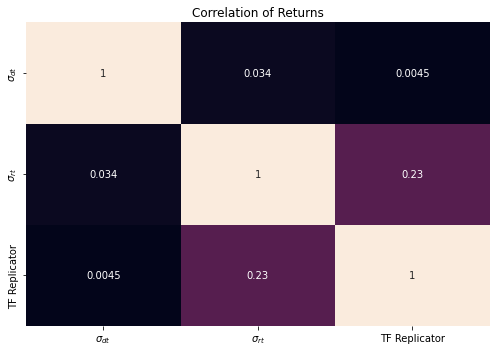

In [15]:
fig, axes = plt.subplots(figsize = (7,5))

(sns.heatmap(
    ax    = axes,
    data  = df_corr,
    cbar  = False,
    annot = True))

axes.set_xlabel("")
axes.set_ylabel("")
axes.set_title("Correlation of Returns")
plt.tight_layout()

Although the volatility difference strategy for $r_t$ delivers a low sharpe it also delivers a low correlation to trend which makes it a good complimentary addition to the trend portfolio.

In [16]:
df_master = (df_signal_rtn.query(
    "signal != 'dt_vol'").
    assign(tmp = lambda x: x.security + " " + x.signal).
    pivot(index = "date", columns = "tmp", values = "signal_rtn").
    apply(lambda x: x * (0.1 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    mean(axis = 1).
    to_frame(name = "port"))

In [17]:
df_port_wider_tmp = (df_port_rtn.query(
    "signal != 'dt_vol'").
    pivot(index = "date", columns = "signal", values = "port_rtn"))

In [18]:
df_combined = (df_master.dropna().query(
    "date != date.min()").
    rename(columns = {"port": "combined"}).
    merge(right = df_port_wider_tmp, how = "inner", on = ["date"]))

The combined portfolio (trend + volatility difference) has an annualized volatility of 1% while the trend and volatility portfolios have around 11%-13% to make the analysis fair I'll volatility target the combined portfolio to 10%. 

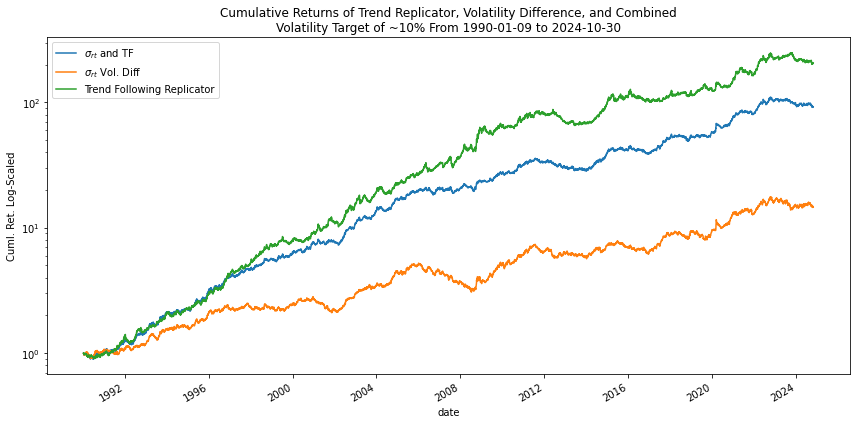

In [19]:
df_plot = (df_combined.assign(
    combined = lambda x: x.combined * (0.1 / (x.combined.ewm(span = 100, adjust = False).std() * np.sqrt(252)))))

renamer = {
        "trend" : "Trend Following Replicator",
        "rt_vol": r"$\sigma_{rt}$" + " Vol. Diff",
        "combined": r"$\sigma_{rt}$" + " and TF"}

(df_plot.apply(
    lambda x: np.cumprod(1 + x)).
    rename(columns = renamer).
    plot(
        figsize = (12,6),
        logy    = True,
        ylabel  = "Cuml. Ret. Log-Scaled",
        title   = "Cumulative Returns of Trend Replicator, Volatility Difference, and Combined\nVolatility Target of ~10% From {} to {}".format(
            df_plot.index.min().date(),
            df_plot.index.max().date())))

plt.tight_layout()

What it lacks in total performance it makes up in sharpe, it delivers a slightly lower annualized return of 13% rather than Trend which delivers about 15% but has less volatility.

In [20]:
(df_plot.agg(
    ["mean", "std"]).
    T.
    rename(columns = {"mean": "mean_rtn", "std": "std_rtn"}).
    assign(
        mean_rtn = lambda x: x.mean_rtn * 252,
        std_rtn  = lambda x: x.std_rtn  * np.sqrt(252),
        sharpe   = lambda x: x.mean_rtn / x.std_rtn).
    sort_values("sharpe").
    rename(columns = {
        "mean_rtn": r"$\mu$",
        "std_rtn" : r"$\sigma$"}).
    reset_index().
    replace(renamer).
    rename(columns = {"index": "strategy"}).
    set_index("strategy").
    apply(lambda x: np.round(x,3)))

,$\mu$,$\sigma$,sharpe
strategy,,,
$\sigma_{rt}$ Vol. Diff,0.081,0.117,0.696
Trend Following Replicator,0.157,0.132,1.186
$\sigma_{rt}$ and TF,0.131,0.099,1.325


In [21]:
df_rolling_sharpe = (df_plot.drop(
    columns = ["rt_vol"]).
    apply(lambda x: x.rolling(window = 60).mean() - x.rolling(window = 60).std()).
    assign(spread = lambda x: x.combined - x.trend).
    dropna())

To ensure that the sharpe overperformance is consistant take the difference of the 60 day rolling sharpe of the combined and trend portoflios. Below is a 1 sample t-test result of those differenced values. 

In [22]:
t_stat, p_value = stats.ttest_1samp(df_rolling_sharpe.spread, popmean=0)
display(pd.DataFrame.from_dict(
    data = {
        "Avg Sharpe Val": df_rolling_sharpe.spread.mean(),
        "T-test"        : t_stat,
        "p-value"       : p_value},
    orient = "index").
    T)

,Avg Sharpe Val,T-test,p-value
0,0.001805,83.435957,0.0


Although the sharpe increase is small it is statistically significant. Although a direct comparison can't be made try adding in $R_t$ volatility differenced model into the Societe Generale Trend Following Model. I'll apply a 1% annualized volatility target on each individual signal's returns and then give equal weight to all signals. Then give a portfolio volatility target of 8% which is the annualized volatility of the Societe Generale Trend Following Index. 

Give a 50%-50% weighting rebalanced daily. The time series can't be accurately combined because the volatility portfolio doesn't incorporate transaction cost, which is difficult since combining the volatility strategy's signal with the trend following signal will change the overall transaction cost. 

In [23]:
df_tf = (pd.read_parquet(
    path = hf_path, engine = "pyarrow").
    query("security == 'NEIXCTA Index'").
    set_index("date")
    [["PX_LAST"]].
    rename(columns = {"PX_LAST": "tf_px"}))

In [24]:
df_vol_port = (df_signal_rtn.query(
    "signal == 'rt_vol'").
    pivot(index = "date", columns = "security", values = "signal_rtn").
    apply(lambda x: x * (0.01 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    mean(axis = 1).
    to_frame(name = "vol_rtn").
    apply(lambda x: x * (0.08 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))))

In [25]:
df_combined = (df_tf.pct_change().merge(
    right = df_vol_port, how = "inner", on = ["date"]).
    assign(combined = lambda x: 0.5 * (x.tf_px + x.vol_rtn)).
    dropna())

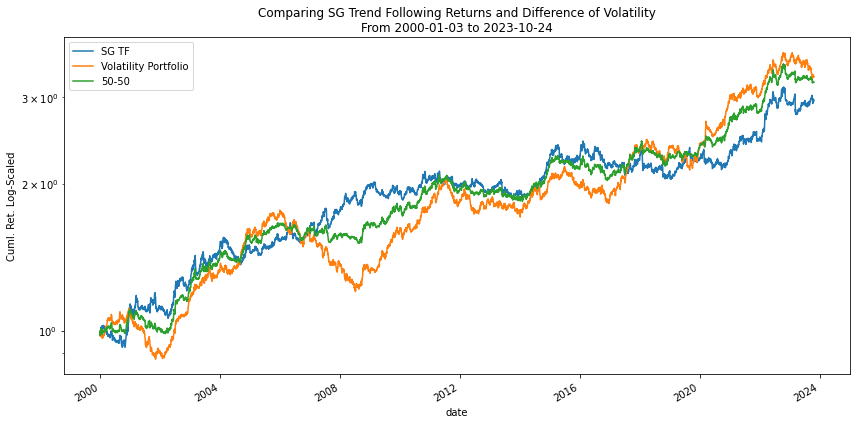

In [26]:
renamer = {
    "tf_px"   : "SG TF",
    "vol_rtn" : "Volatility Portfolio",
    "combined": "50-50"}

(df_combined.apply(
    lambda x: np.cumprod(1 + x)).
    rename(columns = renamer).
    plot(
        figsize = (12,6),
        logy    = True,
        ylabel  = "Cuml. Ret. Log-Scaled",
        title   = "Comparing SG Trend Following Returns and Difference of Volatility\nFrom {} to {}".format(
            df_combined.index.min().date(),
            df_combined.index.max().date())))

plt.tight_layout()

Below is a table of the correlation of returns the volatilty returns has about a 24% correlation to the Trend Following portfolio and has a positive sharpe so it makes a good candidate as a complimentary strategy to the trend following.

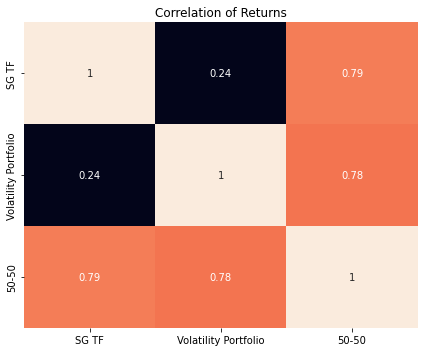

In [27]:
fig, axes = plt.subplots(figsize = (6,5))

sns.heatmap(
    ax    = axes,
    data  = df_combined.rename(columns = renamer).corr(),
    cbar  = False,
    annot = True)

axes.set_title("Correlation of Returns")
plt.tight_layout()

Below is the sharpe comparison, the combined portfolio increases the annualized returns and decreases the standard deviation and creating a sharpe much higher than either of the strategies.

In [28]:
(df_combined.rename(
    columns = renamer).
    agg(["mean", "std"]).
    T.
    rename(columns = {
        "mean": "mean_rtn",
        "std" : "std_rtn"}).
    assign(
        mean_rtn = lambda x: x.mean_rtn * 252,
        std_rtn  = lambda x: x.std_rtn * np.sqrt(252),
        sharpe   = lambda x: x.mean_rtn / x.std_rtn).
    apply(lambda x: np.round(x,3)))

,mean_rtn,std_rtn,sharpe
SG TF,0.047,0.082,0.579
Volatility Portfolio,0.052,0.079,0.652
50-50,0.050,0.064,0.781


The portfolio generates statisticaly significant alpha against the trend following strategy

In [29]:
def _get_factor_exposure(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.tmp_rtn,
        exog  = sm.add_constant(df.tf_px)).
        fit())
    
    df_out = (pd.DataFrame({
        "param_val": model.params,
        "p_values" : model.pvalues,
        "t_stat"   : model.tvalues}))
    
    return df_out

(df_combined.reset_index().melt(
    id_vars = ["date", "tf_px"], value_name = "tmp_rtn").
    set_index("date").
    groupby("variable").
    apply(_get_factor_exposure).
    apply(lambda x: np.round(x,4)).
    reset_index().
    rename(columns = {
        "level_1" : "param",
        "variable": "endog"}).
    replace(renamer))

,endog,param,param_val,p_values,t_stat
0,50-50,const,0.0001,0.0089,2.6169
1,50-50,SG TF,0.6170,0.0000,103.1110
2,Volatility Portfolio,const,0.0002,0.0089,2.6169
3,Volatility Portfolio,SG TF,0.2341,0.0000,19.5574


To add extra validity and check for temporal consistency start by taking the rolling 60d sharpe difference and then testing that distribution with a one sample t-test. From this test the sharpe outperformance is statistically significant. 

In [30]:
def _get_sharpe_ttest(df: pd.DataFrame) -> pd.DataFrame: 
    
    t_stat, p_value = ttest_1samp(df.sharpe_spread, popmean = 0)
    
    df_out = (pd.DataFrame.from_dict({
        "t_stat"  : t_stat,
        "p_value" : p_value,
        "mean_val": df.sharpe_spread.mean()},
        orient = "index"))
    
    return df_out

(df_combined.apply(
    lambda x: x.rolling(window = 60).mean() / x.rolling(window = 60).std()).
    dropna().
    reset_index().
    melt(id_vars = ["date", "tf_px"]).
    assign(sharpe_spread = lambda x: x.value - x.tf_px).
    groupby("variable").
    apply(_get_sharpe_ttest).
    rename(columns = {0: "value"}).
    reset_index().
    rename(columns = {"level_1": ""}).
    replace(renamer).
    pivot(index = "variable", columns = "", values = "value").
    apply(lambda x: np.round(x,4)).
    rename(columns = {"mean_val": "Sharpe Difference"}))

,Sharpe Difference,p_value,t_stat
variable,,,
50-50,0.0108,0.0,8.1356
Volatility Portfolio,0.0108,0.0,4.6400


To run a similar test take a 60d rolling regression to get the alpha of the portfolios against the Trend Following Portfolio, then run a 1 sample t-test on that distribution of alphas. 

In [31]:
def _get_rolling_alpha(df: pd.DataFrame, window: int = 60) -> pd.DataFrame: 
    
    df_tmp = df.set_index("date").sort_index()
    df_out = (RollingOLS(
        endog  = df_tmp.tmp_rtn,
        exog   = sm.add_constant(df_tmp.tf_px),
        window = window).
        fit().
        params
        [["const"]].
        reset_index().
        melt(id_vars = "date"))
    
    return df_out

df_alpha = (df_combined.reset_index().melt(
    id_vars = ["date", "tf_px"], value_name = "tmp_rtn").
    groupby("variable").
    apply(_get_rolling_alpha))

In [32]:
def _get_alpha_ttest(df: pd.DataFrame) -> pd.DataFrame: 
    
    t_stat, p_value = ttest_1samp(df.value, popmean = 0)
    
    df_out = (pd.DataFrame.from_dict({
        "t_stat"  : t_stat,
        "p_value" : p_value,
        "mean_val": df.value.mean()},
        orient = "index"))
    
    return df_out


(df_alpha.drop(
    columns = ["variable"]).
    reset_index().
    drop(columns = ["level_1"]).
    dropna().
    set_index("date").
    groupby("variable").
    apply(_get_alpha_ttest).
    reset_index().
    replace(renamer).
    rename(columns = {
        "level_1": "",
        0        : "value"}).
    pivot(index = "variable", columns = "", values = "value").
    apply(lambda x: np.round(x,4)).
    rename(columns = {"mean_val": "avg. alpha"}))

,avg. alpha,p_value,t_stat
variable,,,
50-50,0.0001,0.0,18.3712
Volatility Portfolio,0.0002,0.0,18.3712
